# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [166]:
# can comment out after executing
!unzip processed_celeba_small.zip

Archive:  processed_celeba_small.zip
replace processed_celeba_small/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [169]:
data_dir = 'processed_celeba_small/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [170]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms

In [171]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    # TODO: Implement function and return a dataloader
    
    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor()
    ])
    
    images = datasets.ImageFolder(data_dir, transform=transform)
    
    return torch.utils.data.DataLoader(images, batch_size=batch_size, shuffle=True)


## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [172]:
# Define function hyperparameters
batch_size = 32
img_size = 32

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


Next, you can view some images! You should seen square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

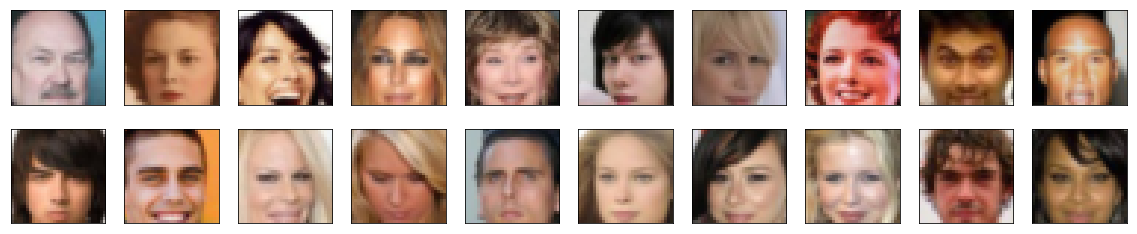

In [173]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [174]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    
    min, max = feature_range
    
    return x * (max - min) + min


In [175]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.7569)
Max:  tensor(0.8353)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [176]:
import torch.nn as nn
import torch.nn.functional as F

In [177]:
def conv(input_size, output_size, kernel_size=4, stride=2, padding=1, use_normalization=True):
    
    layers = []
    layers.append(nn.Conv2d(input_size, output_size, kernel_size, stride=stride, padding=padding, bias=False))
    
    if use_normalization:
        layers.append(nn.BatchNorm2d(output_size))
    
    return nn.Sequential(*layers)

In [178]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim
        
        self.conv1 = conv(3, conv_dim, use_normalization=False)
        self.conv2 = conv(conv_dim, conv_dim * 2)
        self.conv3 = conv(conv_dim * 2, conv_dim * 4)
        
        # Classifier
        self.classifier = nn.Linear(conv_dim * 4 * 4 * 4, 1)
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
        
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        
        x = x.reshape(x.size(0), self.conv_dim * 4 * 4 * 4)
        
        return F.sigmoid(self.classifier(x))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [179]:
def t_conv(input_size, output_size, kernel_size=4, stride=2, padding=1, use_normalization=True):
    
    layers = []
    layers.append(nn.ConvTranspose2d(input_size, output_size, kernel_size, stride=stride, padding=padding, bias=False))
    
    if use_normalization:
        layers.append(nn.BatchNorm2d(output_size))
    
    return nn.Sequential(*layers)

In [180]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()
        self.conv_dim = conv_dim

        # complete init function
        self.fc = nn.Linear(z_size, 4 * 4 * conv_dim * 4)
        
        self.tconv1 = t_conv(conv_dim * 4, conv_dim * 2)
        self.tconv2 = t_conv(conv_dim * 2, conv_dim)
        self.tconv3 = t_conv(conv_dim, 3, use_normalization=False)
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior    
        x = self.fc(x)
        x = x.view(x.size(0), self.conv_dim * 4, 4, 4)
        
        x = F.relu(self.tconv1(x))
        x = F.relu(self.tconv2(x))
        x = F.tanh(self.tconv3(x))
        
        return x

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [181]:
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    # TODO: Apply initial weights to convolutional and linear layers
    if classname.find('BatchNorm2d') != -1 or classname.find('Linear') != -1:
        torch.nn.init.normal_(m.weight.data, 0, 0.02)
#         torch.nn.init.constant(m.bias.weight.data, 0)
    
    

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [232]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


#### Exercise: Define model hyperparameters

In [233]:
# Define model hyperparams
d_conv_dim = 64
g_conv_dim = 64
z_size = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (classifier): Linear(in_features=4096, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=4096, bias=True)
  (tconv1): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (tconv2): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [234]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [235]:
def real_loss(D_out):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
#     criterion = nn.BCEWithLogitsLoss()
#     expected = torch.ones(D_out.size(0), 1)
    
#     if train_on_gpu:
#         expected = expected.to("cuda")
    
#     loss = criterion(D_out, expected)

    return torch.mean((D_out - 1.0) ** 2)

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
#     criterion = nn.BCEWithLogitsLoss()
#     expected = torch.ones(D_out.size(0), 1)
    
#     if train_on_gpu:
#         expected = expected.to("cuda")
    
#     loss = criterion(D_out, expected)
    
    
    return torch.mean(D_out ** 2)

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [236]:
import torch.optim as optim

beta1=0.5
beta2=0.999

# Create optimizers for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(), 0.0001, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), 0.0001, [beta1, beta2])

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [237]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        print("Models to GPU")
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)
            
            if train_on_gpu:
                real_images = real_images.to("cuda")

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            
            ### DISCRIMATOR TRAIN
#             D.train()
#             G.eval()
            
            d_optimizer.zero_grad()
            
            real_d_out = D(real_images)
            real_images_loss = real_loss(real_d_out)
            
            # Train with fake images
            # Generate fake images
            z1 = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z1 = torch.from_numpy(z1).float()
            if train_on_gpu:
                z1 = z1.to("cuda")
            
            fake_images_d = G(z1)
            
            fake_d_out = D(fake_images_d)
            fake_images_loss = fake_loss(fake_d_out)
            
            d_loss = real_images_loss + fake_images_loss
            d_loss.backward()
            
            d_optimizer.step()
                
        
            ### GENERATOR TRAIN
#             D.eval()
#             G.train()
            
            g_optimizer.zero_grad()
            
            # Generate fake images
            z2 = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z2 = torch.from_numpy(z2).float()
            
            if train_on_gpu:
                z2 = z2.to("cuda")
            
            fake_images_g = G(z2)
            
            g_d_output_fake = D(fake_images_g)
            g_loss = real_loss(g_d_output_fake)

            g_loss.backward()
            g_optimizer.step()
            
            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

In [238]:
# set number of epochs 
n_epochs = 30


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
losses = train(D, G, n_epochs=n_epochs)

Models to GPU
Epoch [    1/   30] | d_loss: 0.5026 | g_loss: 0.2540
Epoch [    1/   30] | d_loss: 0.2853 | g_loss: 0.3764
Epoch [    1/   30] | d_loss: 0.0915 | g_loss: 0.6197
Epoch [    1/   30] | d_loss: 0.0437 | g_loss: 0.7342
Epoch [    1/   30] | d_loss: 0.0692 | g_loss: 0.7909
Epoch [    1/   30] | d_loss: 0.0486 | g_loss: 0.7734
Epoch [    1/   30] | d_loss: 0.1527 | g_loss: 0.8654
Epoch [    1/   30] | d_loss: 0.0878 | g_loss: 0.6666
Epoch [    1/   30] | d_loss: 0.1315 | g_loss: 0.7272
Epoch [    1/   30] | d_loss: 0.1703 | g_loss: 0.6371
Epoch [    1/   30] | d_loss: 0.2110 | g_loss: 0.3976
Epoch [    1/   30] | d_loss: 0.1472 | g_loss: 0.6555
Epoch [    1/   30] | d_loss: 0.1067 | g_loss: 0.6925
Epoch [    1/   30] | d_loss: 0.1850 | g_loss: 0.8286
Epoch [    1/   30] | d_loss: 0.1486 | g_loss: 0.7142
Epoch [    1/   30] | d_loss: 0.2384 | g_loss: 0.7107
Epoch [    1/   30] | d_loss: 0.3207 | g_loss: 0.6485
Epoch [    1/   30] | d_loss: 0.3564 | g_loss: 0.7857
Epoch [    1/ 

Epoch [    3/   30] | d_loss: 0.3122 | g_loss: 0.3217
Epoch [    3/   30] | d_loss: 0.3550 | g_loss: 0.4660
Epoch [    3/   30] | d_loss: 0.4889 | g_loss: 0.5436
Epoch [    3/   30] | d_loss: 0.2618 | g_loss: 0.4140
Epoch [    3/   30] | d_loss: 0.3164 | g_loss: 0.2587
Epoch [    3/   30] | d_loss: 0.3094 | g_loss: 0.3852
Epoch [    3/   30] | d_loss: 0.3042 | g_loss: 0.5531
Epoch [    3/   30] | d_loss: 0.2136 | g_loss: 0.5725
Epoch [    3/   30] | d_loss: 0.3812 | g_loss: 0.3606
Epoch [    3/   30] | d_loss: 0.3148 | g_loss: 0.4971
Epoch [    3/   30] | d_loss: 0.3134 | g_loss: 0.5019
Epoch [    3/   30] | d_loss: 0.3082 | g_loss: 0.6249
Epoch [    3/   30] | d_loss: 0.3321 | g_loss: 0.5299
Epoch [    3/   30] | d_loss: 0.2597 | g_loss: 0.3273
Epoch [    3/   30] | d_loss: 0.3777 | g_loss: 0.3271
Epoch [    3/   30] | d_loss: 0.3412 | g_loss: 0.5736
Epoch [    3/   30] | d_loss: 0.3796 | g_loss: 0.4366
Epoch [    3/   30] | d_loss: 0.3561 | g_loss: 0.3455
Epoch [    3/   30] | d_loss

Epoch [    6/   30] | d_loss: 0.1881 | g_loss: 0.4028
Epoch [    6/   30] | d_loss: 0.3644 | g_loss: 0.5440
Epoch [    6/   30] | d_loss: 0.3312 | g_loss: 0.4232
Epoch [    6/   30] | d_loss: 0.2358 | g_loss: 0.6266
Epoch [    6/   30] | d_loss: 0.3015 | g_loss: 0.5443
Epoch [    6/   30] | d_loss: 0.1932 | g_loss: 0.5786
Epoch [    6/   30] | d_loss: 0.3354 | g_loss: 0.6581
Epoch [    6/   30] | d_loss: 0.2695 | g_loss: 0.5468
Epoch [    6/   30] | d_loss: 0.3819 | g_loss: 0.6945
Epoch [    6/   30] | d_loss: 0.2564 | g_loss: 0.2903
Epoch [    6/   30] | d_loss: 0.1659 | g_loss: 0.6084
Epoch [    6/   30] | d_loss: 0.2209 | g_loss: 0.6674
Epoch [    6/   30] | d_loss: 0.2934 | g_loss: 0.5995
Epoch [    6/   30] | d_loss: 0.1765 | g_loss: 0.7413
Epoch [    6/   30] | d_loss: 0.3223 | g_loss: 0.7018
Epoch [    6/   30] | d_loss: 0.2163 | g_loss: 0.3790
Epoch [    6/   30] | d_loss: 0.2934 | g_loss: 0.5433
Epoch [    6/   30] | d_loss: 0.2630 | g_loss: 0.4842
Epoch [    6/   30] | d_loss

Epoch [    9/   30] | d_loss: 0.3032 | g_loss: 0.8407
Epoch [    9/   30] | d_loss: 0.2851 | g_loss: 0.6732
Epoch [    9/   30] | d_loss: 0.1492 | g_loss: 0.7666
Epoch [    9/   30] | d_loss: 0.1331 | g_loss: 0.5949
Epoch [    9/   30] | d_loss: 0.1333 | g_loss: 0.6443
Epoch [    9/   30] | d_loss: 0.1326 | g_loss: 0.6171
Epoch [    9/   30] | d_loss: 0.2030 | g_loss: 0.4170
Epoch [    9/   30] | d_loss: 0.1843 | g_loss: 0.4099
Epoch [    9/   30] | d_loss: 0.1561 | g_loss: 0.7013
Epoch [    9/   30] | d_loss: 0.2184 | g_loss: 0.7650
Epoch [    9/   30] | d_loss: 0.2440 | g_loss: 0.5063
Epoch [    9/   30] | d_loss: 0.1797 | g_loss: 0.5766
Epoch [    9/   30] | d_loss: 0.2756 | g_loss: 0.5076
Epoch [    9/   30] | d_loss: 0.1839 | g_loss: 0.8398
Epoch [    9/   30] | d_loss: 0.0829 | g_loss: 0.6992
Epoch [    9/   30] | d_loss: 0.1739 | g_loss: 0.6999
Epoch [    9/   30] | d_loss: 0.0787 | g_loss: 0.8138
Epoch [    9/   30] | d_loss: 0.1481 | g_loss: 0.5410
Epoch [    9/   30] | d_loss

Epoch [   11/   30] | d_loss: 0.0869 | g_loss: 0.3525
Epoch [   11/   30] | d_loss: 0.2229 | g_loss: 0.7970
Epoch [   11/   30] | d_loss: 0.2180 | g_loss: 0.4743
Epoch [   11/   30] | d_loss: 0.1621 | g_loss: 0.4516
Epoch [   11/   30] | d_loss: 0.2296 | g_loss: 0.6548
Epoch [   11/   30] | d_loss: 0.1375 | g_loss: 0.6925
Epoch [   11/   30] | d_loss: 0.1020 | g_loss: 0.7749
Epoch [   11/   30] | d_loss: 0.0741 | g_loss: 0.7958
Epoch [   11/   30] | d_loss: 0.0833 | g_loss: 0.6406
Epoch [   11/   30] | d_loss: 0.0408 | g_loss: 0.7710
Epoch [   11/   30] | d_loss: 0.0976 | g_loss: 0.7700
Epoch [   11/   30] | d_loss: 0.1200 | g_loss: 0.6805
Epoch [   11/   30] | d_loss: 0.2484 | g_loss: 0.6339
Epoch [   11/   30] | d_loss: 0.0574 | g_loss: 0.5399
Epoch [   11/   30] | d_loss: 0.1493 | g_loss: 0.7144
Epoch [   11/   30] | d_loss: 0.1024 | g_loss: 0.7701
Epoch [   11/   30] | d_loss: 0.1177 | g_loss: 0.6799
Epoch [   11/   30] | d_loss: 0.1391 | g_loss: 0.7244
Epoch [   11/   30] | d_loss

Epoch [   14/   30] | d_loss: 0.1677 | g_loss: 0.6379
Epoch [   14/   30] | d_loss: 0.0928 | g_loss: 0.6016
Epoch [   14/   30] | d_loss: 0.0606 | g_loss: 0.7094
Epoch [   14/   30] | d_loss: 0.0597 | g_loss: 0.7610
Epoch [   14/   30] | d_loss: 0.0943 | g_loss: 0.7302
Epoch [   14/   30] | d_loss: 0.0233 | g_loss: 0.8665
Epoch [   14/   30] | d_loss: 0.2846 | g_loss: 0.7315
Epoch [   14/   30] | d_loss: 0.1137 | g_loss: 0.7335
Epoch [   14/   30] | d_loss: 0.0403 | g_loss: 0.7609
Epoch [   14/   30] | d_loss: 0.0781 | g_loss: 0.6577
Epoch [   14/   30] | d_loss: 0.0446 | g_loss: 0.9004
Epoch [   14/   30] | d_loss: 0.1141 | g_loss: 0.8409
Epoch [   14/   30] | d_loss: 0.0205 | g_loss: 0.8991
Epoch [   14/   30] | d_loss: 0.1894 | g_loss: 0.5461
Epoch [   14/   30] | d_loss: 0.2819 | g_loss: 0.7642
Epoch [   14/   30] | d_loss: 0.1667 | g_loss: 0.5395
Epoch [   14/   30] | d_loss: 0.1054 | g_loss: 0.7648
Epoch [   14/   30] | d_loss: 0.1774 | g_loss: 0.5068
Epoch [   14/   30] | d_loss

Epoch [   17/   30] | d_loss: 0.0668 | g_loss: 0.7780
Epoch [   17/   30] | d_loss: 0.0689 | g_loss: 0.8852
Epoch [   17/   30] | d_loss: 0.0585 | g_loss: 0.8367
Epoch [   17/   30] | d_loss: 0.0208 | g_loss: 0.9036
Epoch [   17/   30] | d_loss: 0.0620 | g_loss: 0.7580
Epoch [   17/   30] | d_loss: 0.0580 | g_loss: 0.8955
Epoch [   17/   30] | d_loss: 0.0068 | g_loss: 0.9180
Epoch [   17/   30] | d_loss: 0.0407 | g_loss: 0.8436
Epoch [   17/   30] | d_loss: 0.0416 | g_loss: 0.8297
Epoch [   17/   30] | d_loss: 0.0638 | g_loss: 0.9548
Epoch [   17/   30] | d_loss: 0.0634 | g_loss: 0.8992
Epoch [   17/   30] | d_loss: 0.1222 | g_loss: 0.5003
Epoch [   17/   30] | d_loss: 0.0601 | g_loss: 0.8278
Epoch [   17/   30] | d_loss: 0.0558 | g_loss: 0.7811
Epoch [   17/   30] | d_loss: 0.0737 | g_loss: 0.7933
Epoch [   17/   30] | d_loss: 0.0066 | g_loss: 0.8831
Epoch [   17/   30] | d_loss: 0.0891 | g_loss: 0.6200
Epoch [   17/   30] | d_loss: 0.0870 | g_loss: 0.8846
Epoch [   17/   30] | d_loss

Epoch [   19/   30] | d_loss: 0.0995 | g_loss: 0.8138
Epoch [   19/   30] | d_loss: 0.0745 | g_loss: 0.8928
Epoch [   19/   30] | d_loss: 0.1302 | g_loss: 0.9331
Epoch [   19/   30] | d_loss: 0.0385 | g_loss: 0.9101
Epoch [   19/   30] | d_loss: 0.0652 | g_loss: 0.7662
Epoch [   19/   30] | d_loss: 0.0274 | g_loss: 0.8133
Epoch [   19/   30] | d_loss: 0.0435 | g_loss: 0.8861
Epoch [   19/   30] | d_loss: 0.0575 | g_loss: 0.6392
Epoch [   19/   30] | d_loss: 0.0325 | g_loss: 0.6693
Epoch [   19/   30] | d_loss: 0.0556 | g_loss: 0.4719
Epoch [   19/   30] | d_loss: 0.0849 | g_loss: 0.8759
Epoch [   19/   30] | d_loss: 0.0185 | g_loss: 0.9258
Epoch [   19/   30] | d_loss: 0.0250 | g_loss: 0.8985
Epoch [   19/   30] | d_loss: 0.1199 | g_loss: 0.6165
Epoch [   19/   30] | d_loss: 0.0369 | g_loss: 0.7588
Epoch [   19/   30] | d_loss: 0.0248 | g_loss: 0.9103
Epoch [   19/   30] | d_loss: 0.0536 | g_loss: 0.8008
Epoch [   19/   30] | d_loss: 0.0793 | g_loss: 0.6958
Epoch [   19/   30] | d_loss

Epoch [   22/   30] | d_loss: 0.0289 | g_loss: 0.8310
Epoch [   22/   30] | d_loss: 0.0622 | g_loss: 0.7573
Epoch [   22/   30] | d_loss: 0.0165 | g_loss: 0.9604
Epoch [   22/   30] | d_loss: 0.1162 | g_loss: 0.9127
Epoch [   22/   30] | d_loss: 0.0484 | g_loss: 0.8327
Epoch [   22/   30] | d_loss: 0.0710 | g_loss: 0.8178
Epoch [   22/   30] | d_loss: 0.1396 | g_loss: 0.9094
Epoch [   22/   30] | d_loss: 0.0204 | g_loss: 0.7340
Epoch [   22/   30] | d_loss: 0.0207 | g_loss: 0.8812
Epoch [   22/   30] | d_loss: 0.0759 | g_loss: 0.7178
Epoch [   22/   30] | d_loss: 0.0270 | g_loss: 0.6715
Epoch [   22/   30] | d_loss: 0.0178 | g_loss: 0.8465
Epoch [   22/   30] | d_loss: 0.0049 | g_loss: 0.9233
Epoch [   22/   30] | d_loss: 0.0257 | g_loss: 0.9297
Epoch [   22/   30] | d_loss: 0.0458 | g_loss: 0.8954
Epoch [   22/   30] | d_loss: 0.1185 | g_loss: 0.7147
Epoch [   22/   30] | d_loss: 0.0172 | g_loss: 0.8831
Epoch [   22/   30] | d_loss: 0.0326 | g_loss: 0.8572
Epoch [   22/   30] | d_loss

Epoch [   25/   30] | d_loss: 0.0262 | g_loss: 0.9007
Epoch [   25/   30] | d_loss: 0.0444 | g_loss: 0.8975
Epoch [   25/   30] | d_loss: 0.0115 | g_loss: 0.9585
Epoch [   25/   30] | d_loss: 0.0593 | g_loss: 0.6543
Epoch [   25/   30] | d_loss: 0.0129 | g_loss: 0.9750
Epoch [   25/   30] | d_loss: 0.0210 | g_loss: 0.7816
Epoch [   25/   30] | d_loss: 0.0090 | g_loss: 0.8874
Epoch [   25/   30] | d_loss: 0.0060 | g_loss: 0.9115
Epoch [   25/   30] | d_loss: 0.1028 | g_loss: 0.8892
Epoch [   25/   30] | d_loss: 0.0427 | g_loss: 0.9524
Epoch [   25/   30] | d_loss: 0.0160 | g_loss: 0.9367
Epoch [   25/   30] | d_loss: 0.0204 | g_loss: 0.7661
Epoch [   25/   30] | d_loss: 0.1079 | g_loss: 0.7422
Epoch [   25/   30] | d_loss: 0.0117 | g_loss: 0.9489
Epoch [   25/   30] | d_loss: 0.0502 | g_loss: 0.7781
Epoch [   25/   30] | d_loss: 0.0471 | g_loss: 0.8386
Epoch [   25/   30] | d_loss: 0.1200 | g_loss: 0.9471
Epoch [   25/   30] | d_loss: 0.0941 | g_loss: 0.8495
Epoch [   25/   30] | d_loss

Epoch [   27/   30] | d_loss: 0.0555 | g_loss: 0.5459
Epoch [   27/   30] | d_loss: 0.0876 | g_loss: 0.7133
Epoch [   27/   30] | d_loss: 0.0283 | g_loss: 0.9010
Epoch [   27/   30] | d_loss: 0.0822 | g_loss: 0.9383
Epoch [   27/   30] | d_loss: 0.0426 | g_loss: 0.8691
Epoch [   27/   30] | d_loss: 0.0514 | g_loss: 0.8755
Epoch [   27/   30] | d_loss: 0.0307 | g_loss: 0.8919
Epoch [   27/   30] | d_loss: 0.0543 | g_loss: 0.7287
Epoch [   27/   30] | d_loss: 0.0093 | g_loss: 0.8951
Epoch [   27/   30] | d_loss: 0.0383 | g_loss: 0.8858
Epoch [   27/   30] | d_loss: 0.0208 | g_loss: 0.8736
Epoch [   27/   30] | d_loss: 0.0765 | g_loss: 0.7378
Epoch [   27/   30] | d_loss: 0.0265 | g_loss: 0.8725
Epoch [   27/   30] | d_loss: 0.1176 | g_loss: 0.8545
Epoch [   27/   30] | d_loss: 0.0120 | g_loss: 0.9341
Epoch [   27/   30] | d_loss: 0.0147 | g_loss: 0.8631
Epoch [   27/   30] | d_loss: 0.1530 | g_loss: 0.9807
Epoch [   27/   30] | d_loss: 0.0918 | g_loss: 0.8355
Epoch [   27/   30] | d_loss

Epoch [   30/   30] | d_loss: 0.0213 | g_loss: 0.9036
Epoch [   30/   30] | d_loss: 0.0113 | g_loss: 0.9683
Epoch [   30/   30] | d_loss: 0.0523 | g_loss: 0.8382
Epoch [   30/   30] | d_loss: 0.0162 | g_loss: 0.9486
Epoch [   30/   30] | d_loss: 0.0606 | g_loss: 0.6308
Epoch [   30/   30] | d_loss: 0.0343 | g_loss: 0.9397
Epoch [   30/   30] | d_loss: 0.0620 | g_loss: 0.9654
Epoch [   30/   30] | d_loss: 0.0384 | g_loss: 0.9088
Epoch [   30/   30] | d_loss: 0.0200 | g_loss: 0.9113
Epoch [   30/   30] | d_loss: 0.0313 | g_loss: 0.9530
Epoch [   30/   30] | d_loss: 0.0482 | g_loss: 0.9580
Epoch [   30/   30] | d_loss: 0.0033 | g_loss: 0.8577
Epoch [   30/   30] | d_loss: 0.0210 | g_loss: 0.6816
Epoch [   30/   30] | d_loss: 0.0059 | g_loss: 0.9582
Epoch [   30/   30] | d_loss: 0.0438 | g_loss: 0.8613
Epoch [   30/   30] | d_loss: 0.0024 | g_loss: 0.9331
Epoch [   30/   30] | d_loss: 0.0194 | g_loss: 0.8602
Epoch [   30/   30] | d_loss: 0.0225 | g_loss: 0.8839
Epoch [   30/   30] | d_loss

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

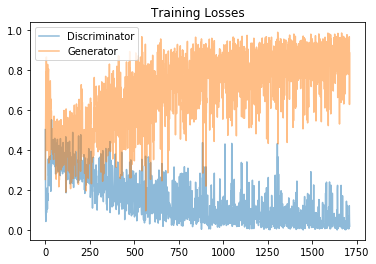

In [239]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [240]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [241]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

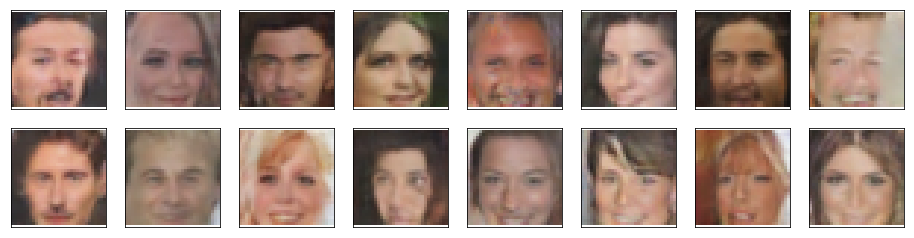

In [247]:
_ = view_samples(-1, samples)

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:** 
First, the generated faces are mostly white woman. Something that should improve the outputs is to have the same number of male and female faces and to have a lot of different skin tone in the dataset.

My model was quite small, I could add more deeper layers in the generator and discriminator

I could also train this network overnight on a lot more epochs to achieve better results.

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.